In [124]:
from clickhouse_driver import Client
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()

password = os.getenv('CLICKHOUSE_PASSWORD')

client = Client(
    host='localhost',
    port=9000,
    database='mma_stats_silver',
    user='default',
    password=password
)

fights_columns = [
    "Athlete_ID",
    "Opponent_ID",
    "Fight_Date",
    "Fight_Result"
]

fights_query = """SELECT Athlete_ID,
                         Opponent_ID,
                         Fight_Date,
                         Fight_Result 
                  FROM ufc_athletes_records"""

fights = pd.DataFrame(client.execute(fights_query), columns=fights_columns)

fights["Fight_Date"] = pd.to_datetime(fights["Fight_Date"])
fights["Delta_Time"] = (datetime.now() - fights["Fight_Date"]).dt.days / 365.25
fights["Delta_Time"] = round(fights["Delta_Time"], 0)

/tmp/ipykernel_22321/588528488.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fights["Fight_Date"] = pd.to_datetime(fights["Fight_Date"])


In [125]:
fights = fights[fights["Fight_Result"].isin(["Victory", "Loss"])]
fights["Fight_Result"] = fights["Fight_Result"].apply(lambda x: 1 if x == "Victory" else 0)

In [126]:
athletes_columns = [
    "Athlete_ID",
    "Wins",
    "Losses",
    "Significant_Strikes_Ratio",
    "Takedowns_Ratio",
    "Fighting_Category",
    "Age",
    "Height",
    "Weight",
    "Reach",
    "Significant_Strikes_Absorbed_Per_Min",
    "Significant_Strikes_Landed_Per_Min",
    "Takedowns_Average_Per_15min", 
    'Win_by_KO/TKO_Count',
    'Win_by_KO/TKO_Percentage',
    'Win_by_DEC_Count',
    'Win_by_DEC_Percentage',
    'Win_by_FIN_Count',
    'Win_by_FIN_Percentage',

]

athletes_query = """SELECT Athlete_ID,
                         Wins,
                         Losses,
                         Significant_Strikes_Ratio,
                         Takedowns_Ratio,
                         Fighting_Category,
                         Age,
                         Height,
                         Weight,
                         Reach,
                         Significant_Strikes_Absorbed_Per_Min,
                         Significant_Strikes_Landed_Per_Min,
                         Takedowns_Average_Per_15min,
                         `Win_by_KO/TKO_Count`,
                         `Win_by_KO/TKO_Percentage`,
                         Win_by_DEC_Count,
                         Win_by_DEC_Percentage,
                         Win_by_FIN_Count,
                         Win_by_FIN_Percentage
                  FROM ufc_athletes"""

athletes = pd.DataFrame(client.execute(athletes_query), columns=athletes_columns)

In [127]:
dataprep = pd.merge(fights, athletes, on='Athlete_ID', how='inner')
dataprep = pd.merge(dataprep, athletes, left_on='Opponent_ID', right_on='Athlete_ID', how='inner')

In [128]:
dataprep["Age_x"] = dataprep["Age_x"] - dataprep["Delta_Time"]
dataprep["Age_y"] = dataprep["Age_y"] - dataprep["Delta_Time"]

In [129]:
def create_fight_key(row):
    fighters = sorted([row['Athlete_ID_x'], row['Opponent_ID']])
    return f"{fighters[0]}_{fighters[1]}_{row['Fight_Date']}"

dataprep['Fight_Key'] = dataprep.apply(create_fight_key, axis=1)
dataprep = dataprep.drop_duplicates(subset=['Fight_Key'])
dataprep = dataprep.drop(columns=['Fight_Key'])

In [130]:
dataprep

,Athlete_ID_x,Opponent_ID,Fight_Date,Fight_Result,Delta_Time,Wins_x,Losses_x,Significant_Strikes_Ratio_x,Takedowns_Ratio_x,Fighting_Category_x,...,Reach_y,Significant_Strikes_Absorbed_Per_Min_y,Significant_Strikes_Landed_Per_Min_y,Takedowns_Average_Per_15min_y,Win_by_KO/TKO_Count_y,Win_by_KO/TKO_Percentage_y,Win_by_DEC_Count_y,Win_by_DEC_Percentage_y,Win_by_FIN_Count_y,Win_by_FIN_Percentage_y
0,Muhammad-Naimov,erik-silva,2024-02-25,1,1.0,11,3,0.436813,0.000000,Striking,...,71.0,1.57,2.07,3.76,3,33.0,2,22.0,4,44.0
1,Muhammad-Naimov,felipe-lima,2024-06-22,0,1.0,11,3,0.436813,0.000000,Striking,...,68.0,2.32,3.50,1.71,4,29.0,7,50.0,3,21.0
2,Muhammad-Naimov,jamie-mullarkey,2023-03-06,1,2.0,11,3,0.436813,0.000000,Striking,...,74.0,4.53,4.39,2.31,10,63.0,3,19.0,3,19.0
3,Muhammad-Naimov,nathaniel-wood,2023-10-21,1,2.0,11,3,0.436813,0.000000,Striking,...,69.0,4.00,5.75,1.56,8,40.0,7,35.0,5,25.0
4,aalon-cruz,uros-medic,2021-07-03,0,4.0,8,4,0.390671,0.000000,Striking,...,71.0,3.46,5.49,0.37,8,80.0,0,0.0,2,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13709,wallid-ismail,yoshiki-takahashi,1997-07-02,0,28.0,0,0,0.000000,0.000000,Grappling,...,0.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0
13765,weili-zhang,xiaonan-yan,2024-04-13,1,1.0,25,3,0.534854,0.018519,Striking,...,63.0,3.44,4.99,0.92,8,42.0,10,53.0,1,5.0
13777,wes-combs,wilson-gouveia,2006-08-25,0,19.0,12,2,0.000000,0.000000,Grappling,...,0.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0
13799,william-gomis,yanis-ghemmouri,2023-02-09,1,2.0,14,2,0.500000,0.375000,Striking,...,69.0,5.14,2.29,0.00,3,25.0,5,42.0,4,33.0


In [131]:
import numpy as np
def create_streak_col(dataprep, atl_id, date_col):
    # Ordenar os dados por atleta e por data (se houver)
    dataprep = dataprep.sort_values([atl_id, date_col])

    # Criar uma coluna que identifica mudanças entre vitórias e derrotas
    dataprep['Mudanca_Resultado'] = (dataprep['Fight_Result'] != dataprep.groupby(atl_id)['Fight_Result'].shift()).cumsum()

    # Calcular a streak para cada atleta
    dataprep[f'Streak_{atl_id}'] = dataprep.groupby([atl_id, 'Mudanca_Resultado']).cumcount() + 1

    # Ajustar para que derrotas apareçam como valores negativos
    dataprep[f'Streak_{atl_id}'] = dataprep[f'Streak_{atl_id}'] * np.where(dataprep['Fight_Result'] == 1, 1, -1)

    return dataprep

In [132]:
dataprep = create_streak_col(dataprep, 'Athlete_ID_x', 'Fight_Date')
dataprep = create_streak_col(dataprep, 'Athlete_ID_y', 'Fight_Date')

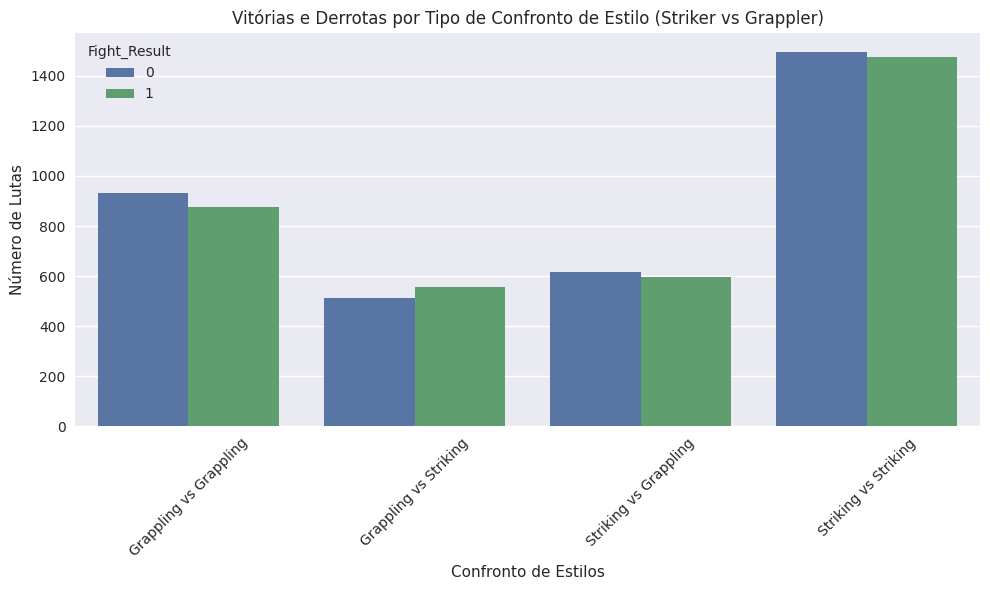

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponha que o DataFrame se chame dataprep
# Tipos possíveis em Fighting_Category: "Striker", "Grappler"

# Criar uma nova coluna indicando o tipo de confronto
dataprep['Fight_Style_Matchup'] = dataprep['Fighting_Category_x'] + ' vs ' + dataprep['Fighting_Category_y']

# Contar vitórias por tipo de confronto
results_by_style = dataprep.groupby(['Fight_Style_Matchup', 'Fight_Result']).size().reset_index(name='Count')

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=results_by_style, x='Fight_Style_Matchup', y='Count', hue='Fight_Result')
plt.title('Vitórias e Derrotas por Tipo de Confronto de Estilo (Striker vs Grappler)')
plt.xlabel('Confronto de Estilos')
plt.ylabel('Número de Lutas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [134]:
import pandas as pd
import matplotlib.pyplot as plt


# Contar vitórias por categoria
wins = dataprep[dataprep['Fight_Result'] == 1].groupby('Fighting_Category_x').size()

# Contar total de lutas por categoria
total = dataprep.groupby('Fighting_Category_x').size()

# Calcular proporção de vitórias
win_ratio = (wins / total).fillna(0).sort_values(ascending=False)


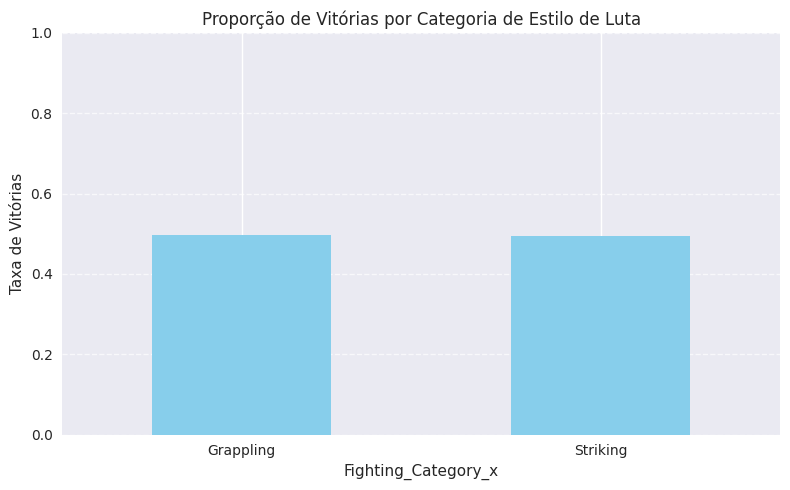

In [135]:

# Plotar gráfico
plt.figure(figsize=(8, 5))
win_ratio.plot(kind='bar', color='skyblue')
plt.ylabel('Taxa de Vitórias')
plt.title('Proporção de Vitórias por Categoria de Estilo de Luta')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [136]:
print("Valores únicos em Fight_Result:", dataprep['Fight_Result'].unique())
print("Quantidade por resultado:\n", dataprep['Fight_Result'].value_counts())
print("Categorias disponíveis:\n", dataprep['Fighting_Category_x'].value_counts())
print("Win ratio calculado:\n", win_ratio)

Valores únicos em Fight_Result: [0 1]
Quantidade por resultado:
 Fight_Result
0    3561
1    3501
Name: count, dtype: int64
Categorias disponíveis:
 Fighting_Category_x
Striking     4185
Grappling    2877
Name: count, dtype: int64
Win ratio calculado:
 Fighting_Category_x
Grappling    0.497046
Striking     0.494863
dtype: float64


In [137]:
dataprep

,Athlete_ID_x,Opponent_ID,Fight_Date,Fight_Result,Delta_Time,Wins_x,Losses_x,Significant_Strikes_Ratio_x,Takedowns_Ratio_x,Fighting_Category_x,...,Win_by_KO/TKO_Count_y,Win_by_KO/TKO_Percentage_y,Win_by_DEC_Count_y,Win_by_DEC_Percentage_y,Win_by_FIN_Count_y,Win_by_FIN_Percentage_y,Mudanca_Resultado,Streak_Athlete_ID_x,Streak_Athlete_ID_y,Fight_Style_Matchup
173,alan-jouban,albert-tumenov,2015-03-10,0,10.0,17,7,0.503035,0.333333,Striking,...,11,65.0,6,35.0,0,0.0,1,-1,-1,Striking vs Striking
36,abdul-razak-alhassan,alessio-di-chirico,2021-08-28,1,4.0,12,7,0.498466,0.066667,Grappling,...,6,46.0,3,23.0,4,31.0,2,1,1,Grappling vs Striking
116,aisling-daly,alex-chambers,2014-12-12,1,10.0,16,5,0.520408,0.000000,Striking,...,4,67.0,1,17.0,1,17.0,3,1,1,Striking vs Striking
328,alex-da-silva,alexander-yakovlev,2019-04-20,0,6.0,21,4,0.463415,0.250000,Striking,...,9,38.0,6,25.0,9,38.0,4,-1,-1,Striking vs Striking
486,alexander-volkov,alexandr-romanov,2023-11-03,1,2.0,38,11,0.573302,0.333333,Grappling,...,6,33.0,3,17.0,9,50.0,5,3,1,Grappling vs Grappling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,hakeem-dawodu,zubaira-tukhugov,2020-09-26,1,5.0,13,4,0.508663,0.000000,Striking,...,7,35.0,12,60.0,1,5.0,4354,3,2,Striking vs Striking
11147,ricardo-ramos,zubaira-tukhugov,2021-10-30,0,4.0,17,6,0.360917,0.111111,Grappling,...,7,35.0,12,60.0,1,5.0,4355,-2,-1,Grappling vs Striking
4165,elves-brener,zubaira-tukhugov,2023-12-02,1,2.0,16,5,0.476471,0.000000,Grappling,...,7,35.0,12,60.0,1,5.0,4356,3,1,Grappling vs Striking
6824,jonathan-martinez,zviad-lazishvili,2021-10-23,1,4.0,19,6,0.495808,0.071429,Striking,...,0,0.0,4,31.0,9,69.0,4357,2,1,Striking vs Striking


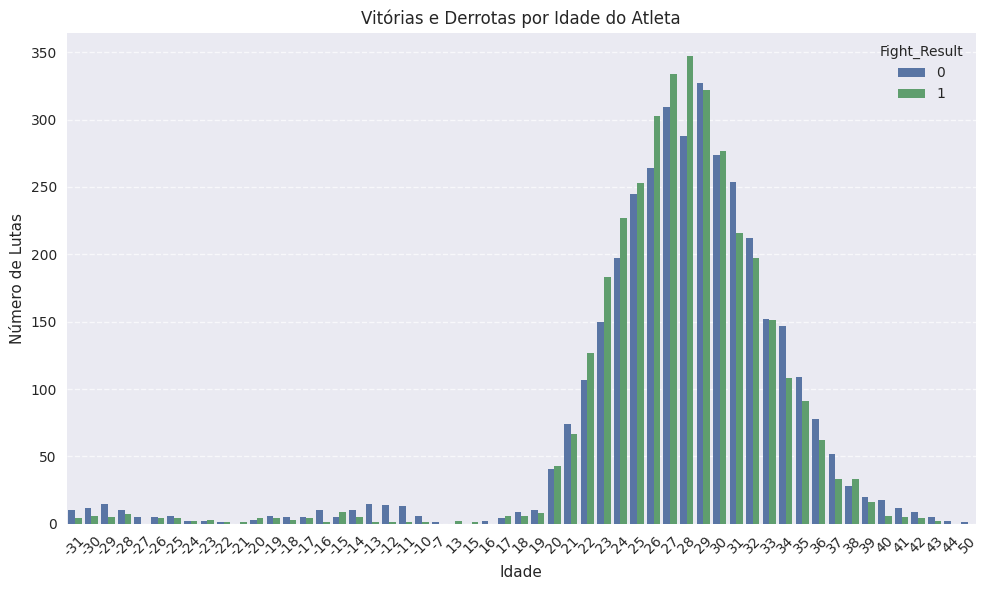

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados válidos
dataprep_age = dataprep[dataprep['Fight_Result'].isin([1, 0])].copy()
dataprep_age = dataprep_age.dropna(subset=['Age_x'])

# Arredondar idade (opcional, se quiser agrupar por idade inteira)
dataprep_age['Age_x'] = dataprep_age['Age_x'].astype(int)

# Agrupar por idade e resultado
age_result = dataprep_age.groupby(['Age_x', 'Fight_Result']).size().reset_index(name='Count')

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=age_result, x='Age_x', y='Count', hue='Fight_Result')
plt.title('Vitórias e Derrotas por Idade do Atleta')
plt.xlabel('Idade')
plt.ylabel('Número de Lutas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


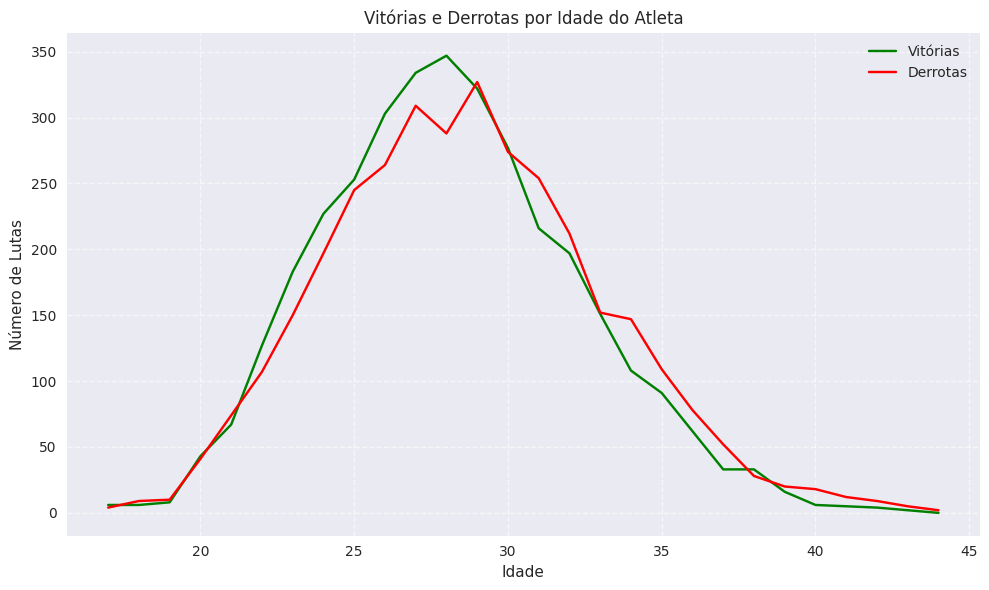

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar e preparar dados
dataprep_age = dataprep[
    (dataprep['Fight_Result'].isin([1, 0])) &
    ((dataprep["Age_x"] >= 17) & (dataprep["Age_x"] <= 45))
].copy()
dataprep_age = dataprep_age.dropna(subset=['Age_x'])
dataprep_age['Age_x'] = dataprep_age['Age_x'].astype(int)

# Agrupar por idade e resultado
age_result = dataprep_age.groupby(['Age_x', 'Fight_Result']).size().unstack(fill_value=0)

# Plotar gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(age_result.index, age_result[1], label='Vitórias', color='green')
plt.plot(age_result.index, age_result[0], label='Derrotas', color='red')
plt.title('Vitórias e Derrotas por Idade do Atleta')
plt.xlabel('Idade')
plt.ylabel('Número de Lutas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


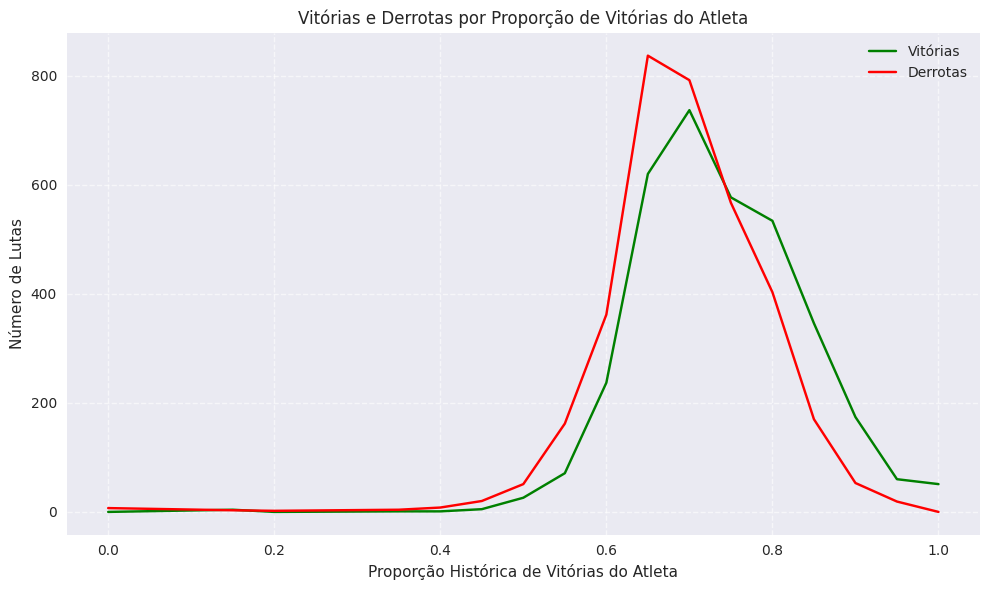

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados válidos
dataprep_ratio = dataprep[dataprep['Fight_Result'].isin([0, 1])].copy()
dataprep_ratio = dataprep_ratio[(dataprep_ratio['Wins_x'] + dataprep_ratio['Losses_x']) > 0]

# Calcular proporção de vitórias do atleta antes da luta
dataprep_ratio['Win_Proportion'] = dataprep_ratio['Wins_x'] / (dataprep_ratio['Wins_x'] + dataprep_ratio['Losses_x'])

# Arredondar para facilitar agrupamento (ex: 0.00 a 1.00 com step 0.05)
dataprep_ratio['Win_Proportion_Bin'] = (dataprep_ratio['Win_Proportion'] * 20).round() / 20

# Agrupar por proporção e contar vitórias e derrotas
grouped = dataprep_ratio.groupby(['Win_Proportion_Bin', 'Fight_Result']).size().unstack(fill_value=0)

# Plotar gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped[1], label='Vitórias', color='green')
plt.plot(grouped.index, grouped[0], label='Derrotas', color='red')
plt.xlabel('Proporção Histórica de Vitórias do Atleta')
plt.ylabel('Número de Lutas')
plt.title('Vitórias e Derrotas por Proporção de Vitórias do Atleta')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_22321/3335458892.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = dataprep_heat.pivot_table(


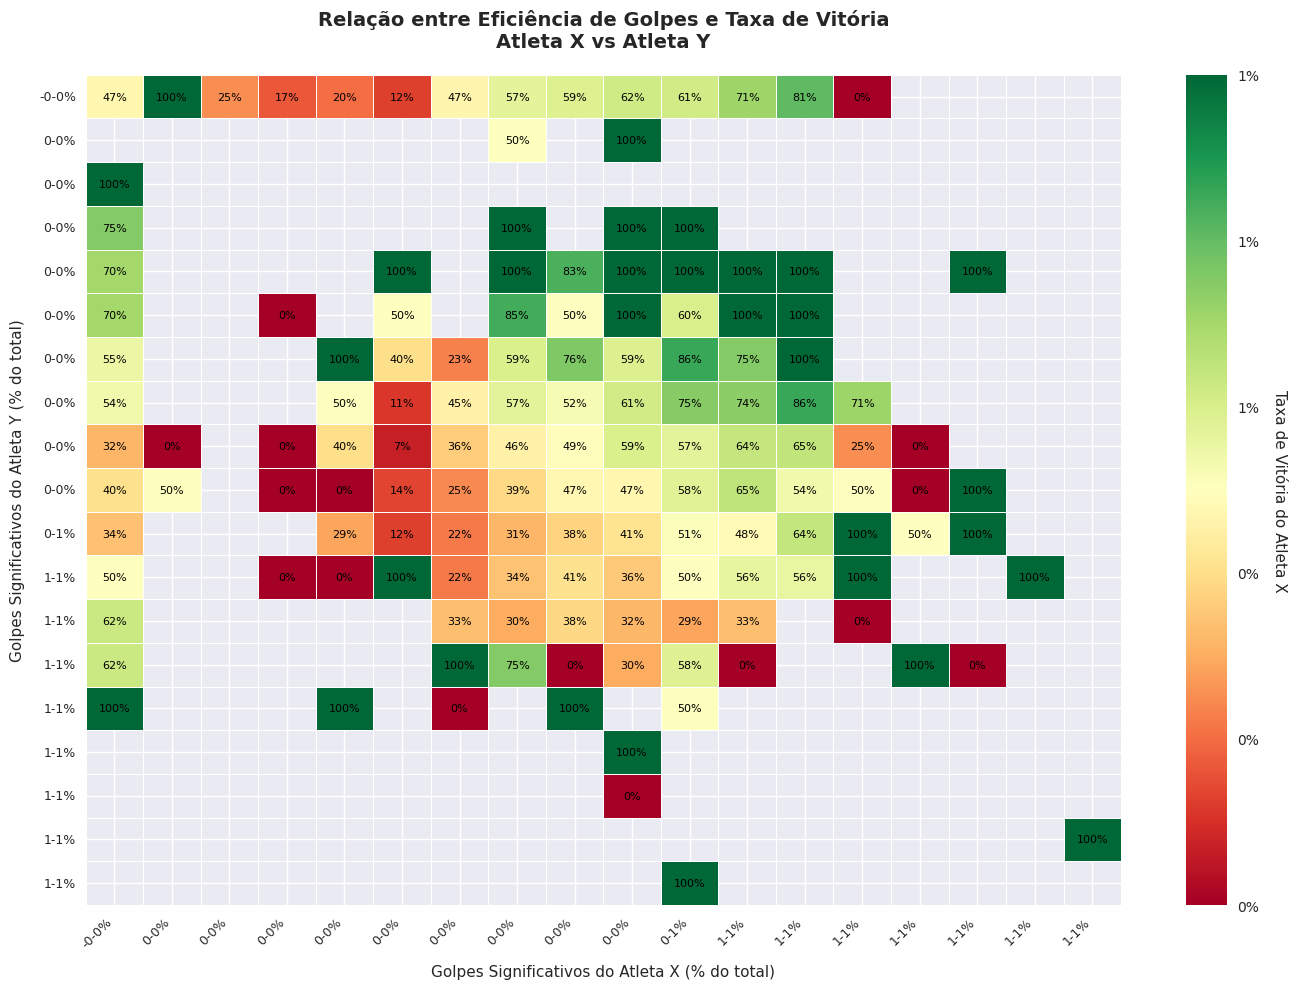

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar o estilo visual
try:
    plt.style.use('seaborn-v0_8')  # Novo nome para o estilo seaborn em versões mais recentes
except:
    plt.style.use('ggplot')  # Fallback para outro estilo bonito

# Filtrar dados válidos
dataprep_heat = dataprep[
    dataprep['Fight_Result'].isin([0, 1])
].copy()
dataprep_heat = dataprep_heat.dropna(subset=['Significant_Strikes_Ratio_x', 'Significant_Strikes_Ratio_y'])

# Criar bins com labels mais limpos
bins = 20
dataprep_heat['Strikes_x_bin'] = pd.cut(dataprep_heat['Significant_Strikes_Ratio_x'], bins=bins)
dataprep_heat['Strikes_y_bin'] = pd.cut(dataprep_heat['Significant_Strikes_Ratio_y'], bins=bins)

# Criar tabela pivot
pivot_table = dataprep_heat.pivot_table(
    index='Strikes_y_bin',
    columns='Strikes_x_bin',
    values='Fight_Result',
    aggfunc='mean'
)

# Formatar os rótulos de forma mais limpa
def format_interval(interval):
    return f"{interval.left:.0f}-{interval.right:.0f}%"

x_labels = [format_interval(interval) for interval in pivot_table.columns]
y_labels = [format_interval(interval) for interval in pivot_table.index]

# Configurar a figura
plt.figure(figsize=(14, 10))

# Criar o heatmap com melhorias
ax = sns.heatmap(
    pivot_table,
    cmap='RdYlGn',  # Paleta divergente vermelho-amarelo-verde
    annot=True,  # Mostrar valores nas células
    fmt=".0%",  # Formato percentual sem decimais
    linewidths=0.5,  # Linhas entre as células
    linecolor='white',  # Cor das linhas
    vmin=0, vmax=1,
    cbar_kws={
        'label': 'Taxa de Vitória do Atleta X',
        'format': '%.0f%%'  # Formato percentual na barra de cores
    },
    annot_kws={
        "size": 8,  # Tamanho da fonte dos valores
        "color": "black"  # Cor do texto
    },
    center=0.5  # Centralizar a paleta em 50%
)

# Melhorar os rótulos
ax.set_xticks(np.arange(len(x_labels)) + 0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.set_yticks(np.arange(len(y_labels)) + 0.5)
ax.set_yticklabels(y_labels, rotation=0, fontsize=9)

# Adicionar título e rótulos
plt.title('Relação entre Eficiência de Golpes e Taxa de Vitória\nAtleta X vs Atleta Y', 
         fontsize=14, pad=20, weight='bold')
plt.xlabel('Golpes Significativos do Atleta X (% do total)', fontsize=11, labelpad=10)
plt.ylabel('Golpes Significativos do Atleta Y (% do total)', fontsize=11, labelpad=10)

# Ajustar a barra de cores
cbar = ax.collections[0].colorbar
cbar.set_label('Taxa de Vitória do Atleta X', rotation=270, labelpad=20, fontsize=11)

# Adicionar linhas de grade para melhor orientação
ax.grid(visible=True, which='minor', color='white', linestyle='-', linewidth=0.5)

# Melhorar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_22321/3180163499.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = dataprep_heat.pivot_table(


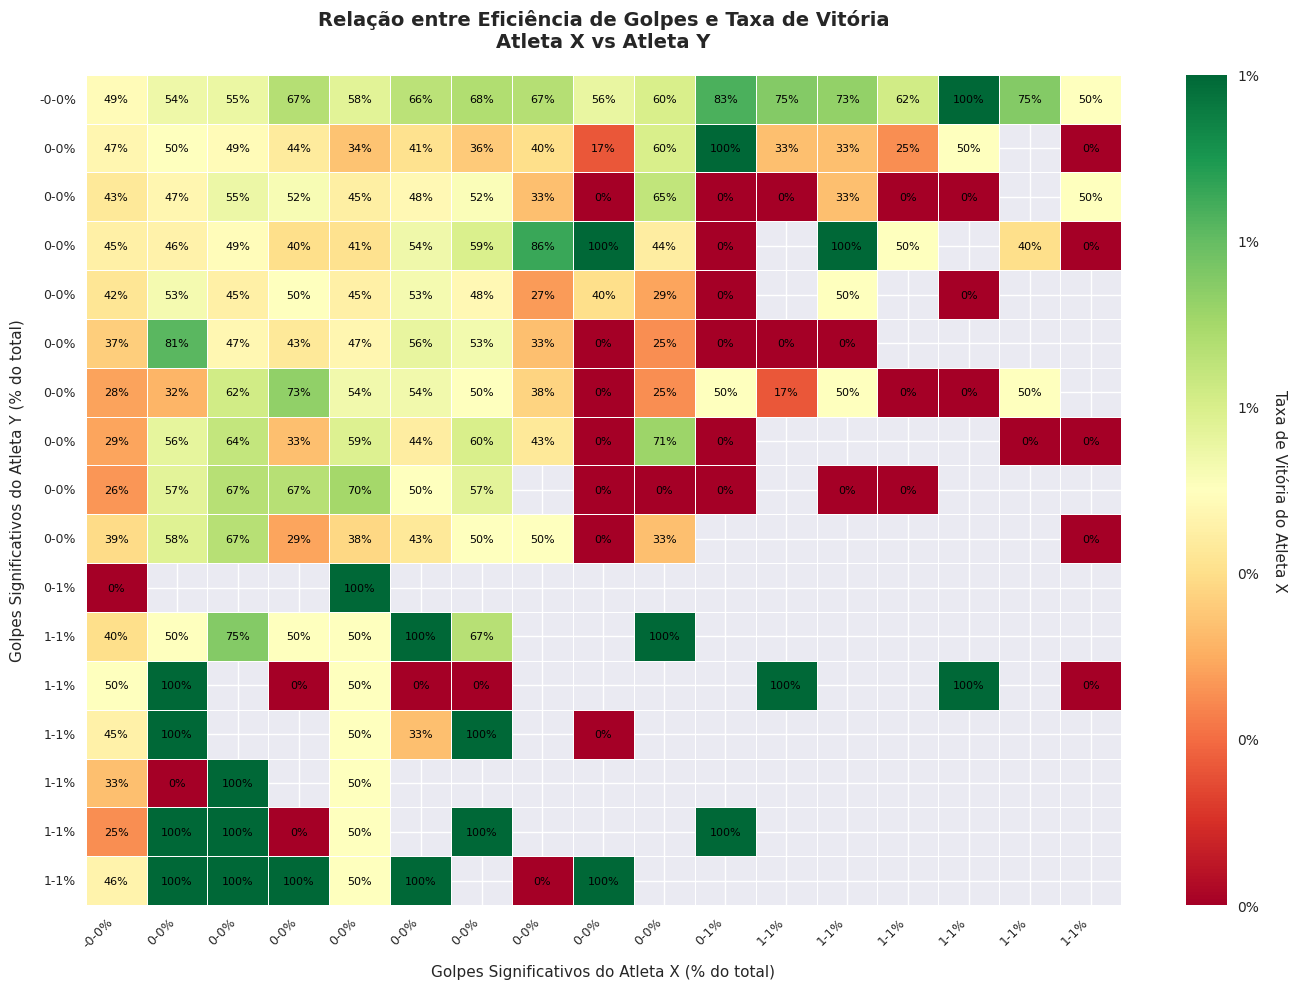

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar o estilo visual
try:
    plt.style.use('seaborn-v0_8')  # Novo nome para o estilo seaborn em versões mais recentes
except:
    plt.style.use('ggplot')  # Fallback para outro estilo bonito

# Filtrar dados válidos
dataprep_heat = dataprep[
    dataprep['Fight_Result'].isin([0, 1])
].copy()
dataprep_heat = dataprep_heat.dropna(subset=['Takedowns_Ratio_x', 'Takedowns_Ratio_y'])

# Criar bins com labels mais limpos
bins = 20
dataprep_heat['Takedowns_x_bin'] = pd.cut(dataprep_heat['Takedowns_Ratio_x'], bins=bins)
dataprep_heat['Takedowns_y_bin'] = pd.cut(dataprep_heat['Takedowns_Ratio_y'], bins=bins)

# Criar tabela pivot
pivot_table = dataprep_heat.pivot_table(
    index='Takedowns_y_bin',
    columns='Takedowns_x_bin',
    values='Fight_Result',
    aggfunc='mean'
)

# Formatar os rótulos de forma mais limpa
def format_interval(interval):
    return f"{interval.left:.0f}-{interval.right:.0f}%"

x_labels = [format_interval(interval) for interval in pivot_table.columns]
y_labels = [format_interval(interval) for interval in pivot_table.index]

# Configurar a figura
plt.figure(figsize=(14, 10))

# Criar o heatmap com melhorias
ax = sns.heatmap(
    pivot_table,
    cmap='RdYlGn',  # Paleta divergente vermelho-amarelo-verde
    annot=True,  # Mostrar valores nas células
    fmt=".0%",  # Formato percentual sem decimais
    linewidths=0.5,  # Linhas entre as células
    linecolor='white',  # Cor das linhas
    vmin=0, vmax=1,
    cbar_kws={
        'label': 'Taxa de Vitória do Atleta X',
        'format': '%.0f%%'  # Formato percentual na barra de cores
    },
    annot_kws={
        "size": 8,  # Tamanho da fonte dos valores
        "color": "black"  # Cor do texto
    },
    center=0.5  # Centralizar a paleta em 50%
)

# Melhorar os rótulos
ax.set_xticks(np.arange(len(x_labels)) + 0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.set_yticks(np.arange(len(y_labels)) + 0.5)
ax.set_yticklabels(y_labels, rotation=0, fontsize=9)

# Adicionar título e rótulos
plt.title('Relação entre Eficiência de Golpes e Taxa de Vitória\nAtleta X vs Atleta Y', 
         fontsize=14, pad=20, weight='bold')
plt.xlabel('Golpes Significativos do Atleta X (% do total)', fontsize=11, labelpad=10)
plt.ylabel('Golpes Significativos do Atleta Y (% do total)', fontsize=11, labelpad=10)

# Ajustar a barra de cores
cbar = ax.collections[0].colorbar
cbar.set_label('Taxa de Vitória do Atleta X', rotation=270, labelpad=20, fontsize=11)

# Adicionar linhas de grade para melhor orientação
ax.grid(visible=True, which='minor', color='white', linestyle='-', linewidth=0.5)

# Melhorar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [143]:
dataprep

,Athlete_ID_x,Opponent_ID,Fight_Date,Fight_Result,Delta_Time,Wins_x,Losses_x,Significant_Strikes_Ratio_x,Takedowns_Ratio_x,Fighting_Category_x,...,Win_by_KO/TKO_Count_y,Win_by_KO/TKO_Percentage_y,Win_by_DEC_Count_y,Win_by_DEC_Percentage_y,Win_by_FIN_Count_y,Win_by_FIN_Percentage_y,Mudanca_Resultado,Streak_Athlete_ID_x,Streak_Athlete_ID_y,Fight_Style_Matchup
173,alan-jouban,albert-tumenov,2015-03-10,0,10.0,17,7,0.503035,0.333333,Striking,...,11,65.0,6,35.0,0,0.0,1,-1,-1,Striking vs Striking
36,abdul-razak-alhassan,alessio-di-chirico,2021-08-28,1,4.0,12,7,0.498466,0.066667,Grappling,...,6,46.0,3,23.0,4,31.0,2,1,1,Grappling vs Striking
116,aisling-daly,alex-chambers,2014-12-12,1,10.0,16,5,0.520408,0.000000,Striking,...,4,67.0,1,17.0,1,17.0,3,1,1,Striking vs Striking
328,alex-da-silva,alexander-yakovlev,2019-04-20,0,6.0,21,4,0.463415,0.250000,Striking,...,9,38.0,6,25.0,9,38.0,4,-1,-1,Striking vs Striking
486,alexander-volkov,alexandr-romanov,2023-11-03,1,2.0,38,11,0.573302,0.333333,Grappling,...,6,33.0,3,17.0,9,50.0,5,3,1,Grappling vs Grappling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,hakeem-dawodu,zubaira-tukhugov,2020-09-26,1,5.0,13,4,0.508663,0.000000,Striking,...,7,35.0,12,60.0,1,5.0,4354,3,2,Striking vs Striking
11147,ricardo-ramos,zubaira-tukhugov,2021-10-30,0,4.0,17,6,0.360917,0.111111,Grappling,...,7,35.0,12,60.0,1,5.0,4355,-2,-1,Grappling vs Striking
4165,elves-brener,zubaira-tukhugov,2023-12-02,1,2.0,16,5,0.476471,0.000000,Grappling,...,7,35.0,12,60.0,1,5.0,4356,3,1,Grappling vs Striking
6824,jonathan-martinez,zviad-lazishvili,2021-10-23,1,4.0,19,6,0.495808,0.071429,Striking,...,0,0.0,4,31.0,9,69.0,4357,2,1,Striking vs Striking


In [144]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline  # Note: Using imblearn's Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Generate differences
numeric_features = ['Age', 'Height', 'Weight', 'Reach', 'Streak_Athlete_ID',
                    'Significant_Strikes_Ratio', 'Takedowns_Ratio']

for feat in numeric_features:
    dataprep[f'{feat}_diff'] = dataprep[f'{feat}_x'] - dataprep[f'{feat}_y']

dataprep = dataprep[[
    "Athlete_ID_x",
    "Fight_Result",
    "Wins_x",
    "Losses_x",
    "Takedowns_Ratio_x",
    "Fighting_Category_x",
    "Age_x",
    "Streak_Athlete_ID_x",
    "Significant_Strikes_Ratio_x",
	
    "Athlete_ID_y",
    "Wins_y",
    "Losses_y",
    "Fighting_Category_y",
    "Age_y",
    "Streak_Athlete_ID_y",
    "Takedowns_Ratio_y",
    "Significant_Strikes_Ratio_y",
	
    "Fight_Style_Matchup",
    "Age_diff",
    "Height_diff",
    "Weight_diff",
    "Reach_diff",
    "Significant_Strikes_Ratio_diff",
    "Takedowns_Ratio_diff",
    "Streak_Athlete_ID_diff",

]]

# Split data
X = dataprep.drop(columns=['Fight_Result'])
y = dataprep['Fight_Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num_std', StandardScaler(), [f'{feat}_diff' for feat in numeric_features]),
        ('num_norm', MinMaxScaler(), ['Significant_Strikes_Ratio_x', 'Takedowns_Ratio_x',
                                     'Significant_Strikes_Ratio_y', 'Takedowns_Ratio_y', 
                                     'Wins_x', 'Wins_y', 'Losses_x', 'Losses_y']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Fighting_Category_x', 'Fighting_Category_y'])
    ])

# Use imblearn's Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('under_sampler', RandomUnderSampler(random_state=42)),
    # ('over_sampler', SMOTE(random_state=42)),
    ('model', XGBClassifier(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1, eval_metric='logloss'))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)






import pandas as pd
import numpy as np

# Obter o modelo final (XGBClassifier) do pipeline
model = pipeline.named_steps['model']

# Obter o pré-processador já ajustado
preprocessor_fitted = pipeline.named_steps['preprocessor']

# Reconstruir a lista de nomes das features após transformação
num_std_feats = [f'{feat}_diff' for feat in numeric_features]
num_norm_feats = ['Significant_Strikes_Ratio_x', 'Takedowns_Ratio_x',
                  'Significant_Strikes_Ratio_y', 'Takedowns_Ratio_y',
                  'Wins_x', 'Wins_y', 'Losses_x', 'Losses_y']
cat_feats = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(
    ['Fighting_Category_x', 'Fighting_Category_y']
)

# Concatenar todos os nomes de features na ordem usada pelo modelo
feature_names = np.concatenate([num_std_feats, num_norm_feats, cat_feats])

# Obter importâncias
importances = model.feature_importances_

# Criar e exibir DataFrame ordenado
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (ordered):")
feat_importances


Feature Importances (ordered):


,Feature,Importance
5,Significant_Strikes_Ratio_diff,0.141287
12,Wins_y,0.102843
11,Wins_x,0.081788
14,Losses_y,0.081540
3,Reach_diff,0.069631
13,Losses_x,0.064948
10,Takedowns_Ratio_y,0.056125
2,Weight_diff,0.055027
7,Significant_Strikes_Ratio_x,0.046376
9,Significant_Strikes_Ratio_y,0.044236


In [145]:
feature_names

array(['Age_diff', 'Height_diff', 'Weight_diff', 'Reach_diff',
       'Streak_Athlete_ID_diff', 'Significant_Strikes_Ratio_diff',
       'Takedowns_Ratio_diff', 'Significant_Strikes_Ratio_x',
       'Takedowns_Ratio_x', 'Significant_Strikes_Ratio_y',
       'Takedowns_Ratio_y', 'Wins_x', 'Wins_y', 'Losses_x', 'Losses_y',
       'Fighting_Category_x_Grappling', 'Fighting_Category_x_Striking',
       'Fighting_Category_y_Grappling', 'Fighting_Category_y_Striking'],
      dtype=object)

In [146]:
from sklearn.metrics import classification_report, confusion_matrix
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       707
           1       0.72      0.69      0.70       706

    accuracy                           0.71      1413
   macro avg       0.71      0.71      0.71      1413
weighted avg       0.71      0.71      0.71      1413


Confusion Matrix:
[[515 192]
 [219 487]]


In [147]:
dataprep.to_csv('dados_ml.csv')

In [148]:
data = [
    ['alex-pereira', 12, 2, 0.0, 'Striking', 37.0, 5, 0.6308360477741585,
     'magomed-ankalaev', 20, 1, 0.0, 'Striking', 32.0, 12, 0.5290437890974083,
     'Striking vs Striking', 5.0, 1.0, 0.5, 4.0, 0.101792, 0.0, -7]
]

# Colunas
columns = [
    'Athlete_ID_x', 'Wins_x', 'Losses_x', 'Takedowns_Ratio_x',
    'Fighting_Category_x', 'Age_x', 'Streak_Athlete_ID_x',
    'Significant_Strikes_Ratio_x', 'Athlete_ID_y', 'Wins_y', 'Losses_y',
    'Fighting_Category_y', 'Age_y', 'Streak_Athlete_ID_y',
    'Takedowns_Ratio_y', 'Significant_Strikes_Ratio_y',
    'Fight_Style_Matchup', 'Age_diff', 'Height_diff', 'Weight_diff',
    'Reach_diff', 'Significant_Strikes_Ratio_diff', 'Takedowns_Ratio_diff',
    'Streak_Athlete_ID_diff'
]

# Criar DataFrame
df_ank_poatan = pd.DataFrame(data, columns=columns)

In [149]:
df_ank_poatan

,Athlete_ID_x,Wins_x,Losses_x,Takedowns_Ratio_x,Fighting_Category_x,Age_x,Streak_Athlete_ID_x,Significant_Strikes_Ratio_x,Athlete_ID_y,Wins_y,...,Takedowns_Ratio_y,Significant_Strikes_Ratio_y,Fight_Style_Matchup,Age_diff,Height_diff,Weight_diff,Reach_diff,Significant_Strikes_Ratio_diff,Takedowns_Ratio_diff,Streak_Athlete_ID_diff
0,alex-pereira,12,2,0.0,Striking,37.0,5,0.630836,magomed-ankalaev,20,...,12,0.529044,Striking vs Striking,5.0,1.0,0.5,4.0,0.101792,0.0,-7


In [150]:
cols_to_float = [
    'Takedowns_Ratio_x', 'Age_x', 'Significant_Strikes_Ratio_x',
    'Takedowns_Ratio_y', 'Significant_Strikes_Ratio_y', 'Age_y',
    'Age_diff', 'Height_diff', 'Weight_diff', 'Reach_diff',
    'Significant_Strikes_Ratio_diff', 'Takedowns_Ratio_diff'  # estava como float em df_ank_poatan, mas int em A — vamos forçar como int
]

cols_to_int = [
    'Wins_x', 'Losses_x', 'Streak_Athlete_ID_x',
    'Wins_y', 'Losses_y', 'Streak_Athlete_ID_diff',
    'Streak_Athlete_ID_y'
]

cols_to_object = [
    'Athlete_ID_x', 'Fighting_Category_x', 'Athlete_ID_y',
    'Fighting_Category_y', 'Fight_Style_Matchup'
]

# Corrigir tipos
for col in cols_to_float:
    df_ank_poatan[col] = pd.to_numeric(df_ank_poatan[col], errors='coerce')

for col in cols_to_int:
    df_ank_poatan[col] = pd.to_numeric(df_ank_poatan[col], errors='coerce').astype('Int64')  # usa nullable int

for col in cols_to_object:
    df_ank_poatan[col] = df_ank_poatan[col].astype(str)

In [152]:
pipeline.predict(df_ank_poatan)

array([0])